In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random

In [2]:
# local directory of images
file_dir = '../XN_Files/'

In each category, there are four images of the same brain. Each one of them has a different view/resolution that we can use to determine the class of hemhorrage.

../XN_Files/epidural/brain_bone_window/ID_0a3f30540.jpg


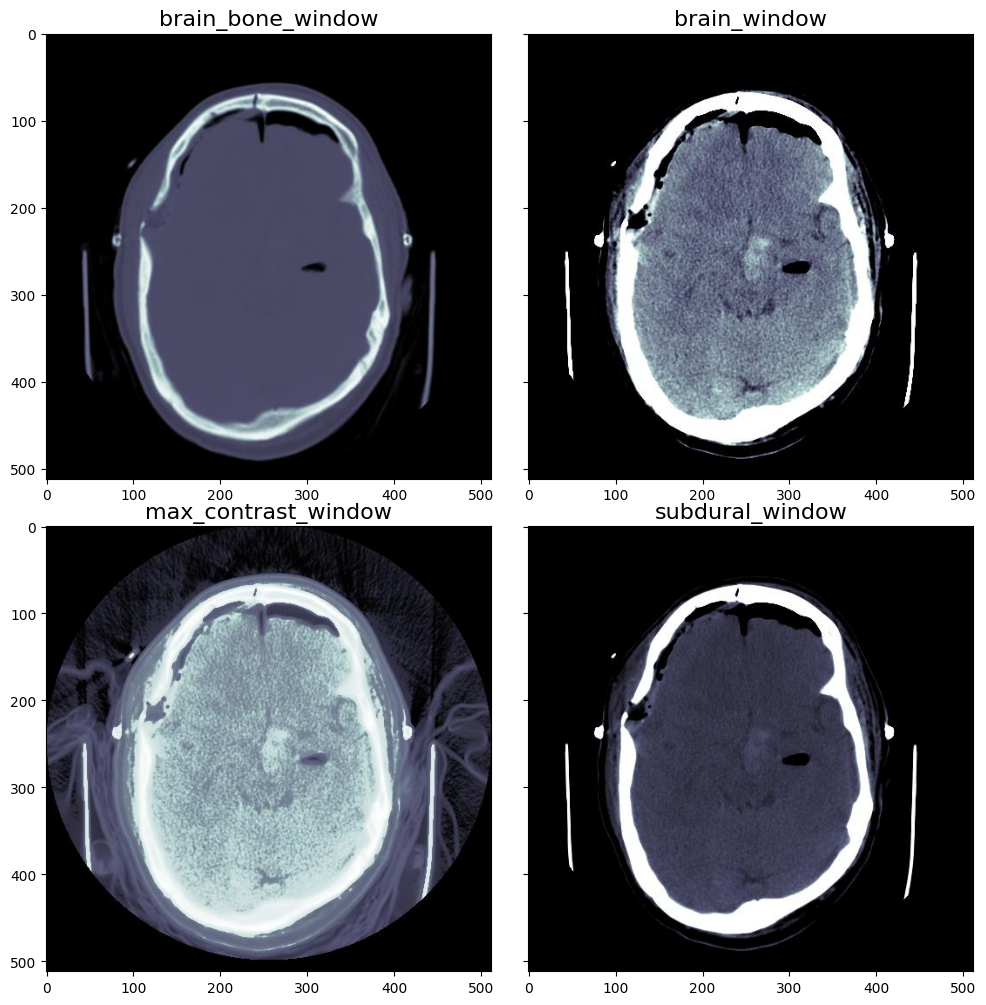

In [3]:
epidural = 'epidural/'
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'

image_types = [(brain_bone, 0), (brain_w, 1), (max_con, 2), (subdural, 3)]

images = [mpimg.imread(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  brain_w + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  max_con + '/ID_0a3f30540.jpg'),
         mpimg.imread(file_dir + epidural +  subdural + '/ID_0a3f30540.jpg')]

print(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg')

f, axes = plt.subplots(2, 2, sharey = True)
f.set_size_inches(10,10)
f.tight_layout()

axes = axes.reshape(4)

for i, j in zip(images, image_types):
    axes[j[1]].imshow(i)
    axes[j[1]].set_title(j[0], fontsize=16)


### Loading and Cleaning the Segmentation Files

In [4]:
#### Rename files for easiser processing -> ex. epidural.csv ###

In [5]:
# local directory of images
file_dir = '../XN_Files/'


#image types
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'


#image size
im_size = 512*512

In [6]:
def convert_coordinates(coords):
    result = []
    for coord in eval(coords):
        result.append((np.array([[pair['x'], pair['y']] for pair in coord]) * 512).astype(int))
    return result

In [7]:
def load_labels(f_dir: str, image_type: str) -> pd.DataFrame:
    """Function to get hemmorhage labels. Method prerequisite: rename result csv files to match type_labels dict -> ex. epidural.csv, multi.csv"""
    # set class designations and relevant columns
    type_labels = {'epidural': 1, 'intraparenchymal': 2, 'subarachnoid': 3, 'subdural': 4, 'multi': 5,}
    column_names = ["Origin","Labeling State","All Labels","Majority Label", "Correct Label"]
    labels = pd.DataFrame()
    
    # for each hemorrhage type, load label data
    for k,v in type_labels.items():
        temp_data = pd.read_csv(file_dir + './Hemorrhage Segmentation Project/' + k + '.csv')
        temp_data = temp_data[column_names]
        temp_data['Hemorrhage Type'] = k
        temp_data['Class'] = v
        labels = pd.concat([labels, temp_data])
        
    # drop all rows that are not labeled
    labeled = labels[labels['Labeling State']=='Labeled']
    gold = labels[labels['Labeling State']=='Gold Standard']
    labeled_df = pd.concat([labeled, gold]).dropna().reset_index().drop(['index'],axis = 1)
    

    
    # filter labeled images - only take images which hold correct labels
    labeled_df['Correct_Present'] = labeled_df['Correct Label'].apply(lambda x: 1 if "x" in x else 0)    
    labeled_df = labeled_df[labeled_df.Correct_Present==1].reset_index().drop(['index','Correct_Present'],axis = 1)
    
    
    # drop duplicates
    labeled_df = labeled_df.drop_duplicates(subset=['Origin']).reset_index().drop(['index'],axis = 1)
    
    # drop images with il-formatted coordinates
    labeled_df = labeled_df[labeled_df.Origin!='ID_6168d766c.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_1e643d438.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_233344b54.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_a39f8e984.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_acef57288.jpg']
    
    
    # convert coordinates for opencv use
    labeled_df["X-Y_segment"] = labeled_df['Correct Label'].apply(convert_coordinates)

    
    # add normal sample
    normal_sample_size = 500
    normal_images = os.listdir(file_dir + 'normal/' + image_type + '/')
    random.seed(123)
    normal_sample = random.sample(normal_images, k=normal_sample_size)
    norm_df = pd.DataFrame(normal_sample, columns=['Origin'])
    norm_df = norm_df.assign(**{ x : 'NA' for x in column_names[1:] })
    norm_df['Hemorrhage Type'] = 'normal'
    norm_df['Class'] = 6
    
    # final df
    final_labels = pd.concat([labeled_df, norm_df]).reset_index().drop(['index','All Labels','Majority Label'],axis = 1)
    final_labels['Image Type'] = image_type
    
    
    
    return final_labels

In [8]:
# load label data, specify brain_bone_window
labels = load_labels(file_dir, brain_bone)
labels

/var/folders/7t/3srvl3rx4fl_ywrtcrwk4q6rz8g73f/T/ipykernel_58637/698692476.py:10: DtypeWarning: Columns (0,5,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,2

,Origin,Labeling State,Correct Label,Hemorrhage Type,Class,X-Y_segment,Image Type
0,ID_004c4b319.jpg,Labeled,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,"[[[275, 458], [275, 457], [274, 457], [271, 45...",brain_bone_window
1,ID_02e2d273d.jpg,Labeled,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,"[[[238, 183], [238, 182], [237, 182], [229, 18...",brain_bone_window
2,ID_03c6a01ca.jpg,Labeled,"[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,"[[[282, 372], [282, 371], [281, 371], [280, 37...",brain_bone_window
3,ID_045196c9f.jpg,Labeled,"[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,"[[[303, 405], [303, 401], [304, 401], [304, 39...",brain_bone_window
4,ID_0513bfa29.jpg,Labeled,"[[{'x': 0.78125, 'y': 0.6875}, {'x': 0.78125, ...",epidural,1,"[[[400, 352], [400, 344], [399, 344], [399, 34...",brain_bone_window
...,...,...,...,...,...,...,...
1830,ID_002136e63.jpg,NA,NA,normal,6,NaN,brain_bone_window
1831,ID_008c2125f.jpg,NA,NA,normal,6,NaN,brain_bone_window
1832,ID_028898832.jpg,NA,NA,normal,6,NaN,brain_bone_window
1833,ID_033288e3e.jpg,NA,NA,normal,6,NaN,brain_bone_window


In [9]:
# In case we want to examine the data manually
# labels.to_excel("data.xlsx", index = False)

In [29]:
def load_data_per_image_type(file_dir: str, labels: pd.DataFrame, im_size: int) -> np.array([]):
    data = np.zeros([labels.shape[0], im_size])
    y = np.zeros([labels.shape[0],]).astype(int)
    print(f'Data Shape: {data.shape}', f'Label Shape: {y.shape}')
    for index, row in labels.iterrows():
        try:
            data[index,:] = np.mean(mpimg.imread(file_dir + row['Hemorrhage Type'] +'/'+ row['Image Type'] + '/' + row['Origin']), axis=2).reshape(-1)
            y[index] = row['Class']
        except Exception as e:
            print(f"Image {row['Origin']} is an incompatible size, skipping")
            continue   
    return data, y

In [30]:
X, y = load_data_per_image_type(file_dir, labels, im_size)

Data Shape: (1835, 262144) Label Shape: (1835,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [31]:
def downsize_data(X, y): 

    DS = 4

    N = y.shape[0]  # The length of the training data

    if 262144/DS % 1 > 0:
        print("Downsample rate is not a multiple of 262144")
        DS = 1
        im_size = 262144
    else:
        im_size = int(262144/DS)

    Xds = np.zeros([N*DS, im_size])
    yds = np.zeros([N*DS, 1])


    for n in range(N):
        for i in range(DS):
            Xds[n+i,:] = X[n,i::DS]
            yds[n+i] = y[n]


    print(f'X shape: {Xds.shape}')
    print(f'y shape: {yds.shape}')
    
    return Xds, yds

In [32]:
X, y = downsize_data(X, y)

X shape: (7340, 65536)
y shape: (7340, 1)


#### Load data for max contrast window


In [33]:
# max_contrast_window
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)

/var/folders/7t/3srvl3rx4fl_ywrtcrwk4q6rz8g73f/T/ipykernel_58637/698692476.py:10: DtypeWarning: Columns (0,5,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,2

Data Shape: (1835, 262144) Label Shape: (1835,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


**Analysis Setup**

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [35]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (1559, 262144), y: (1559,)
Test Data Shape -> X: (276, 262144), y: (276,)


In [36]:
Xds_train, yds_train = downsize_data(X_train, y_train)
Xds_test, yds_test = downsize_data(X_test, y_test)

X shape: (6236, 65536)
y shape: (6236, 1)
X shape: (1104, 65536)
y shape: (1104, 1)


**Logistic Regression**

In [28]:
# tune our hyperparamters
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'max_iter': [1, 10, 50, 100] }

lr = LogisticRegression(solver='lbfgs')

grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best Hyperparameters: {grid_search.best_params_}')

# Logistic regression with best hyperparams
best_lr = grid_search._best_estimator_
y_pred = best_lr.fit(X_train, y_train)
accuracy = best_lr.score(X_test, y_test)
print(f'Accuracy = {accuracy}')


/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
Process LokyProcess-18:
Traceback (most recent call last):
  File "/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*args, **kwargs)
  File "/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "/Users

KeyboardInterrupt: 

In [37]:
clf = LogisticRegression(solver='lbfgs', max_iter=100)
clf.fit(Xds_train, yds_train)
print("Logistic Regression Score: %.3f"%clf.score(Xds_test, yds_test))

/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Score: 0.829


**LDA**

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [21]:
lda = LinearDiscriminantAnalysis(store_covariance=False)
lda.fit(X_train, y_train)
print("LDA Score: %.3f"%lda.score(X_test, y_test))

LDA Score: 0.337


## Segmentation


In [33]:
from collections import Counter
import ast
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

import os
os.environ['QT_BACKEND'] = 'osx'

import cv2

In [23]:
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels.to_csv("segment.csv", index = False)

/var/folders/7t/3srvl3rx4fl_ywrtcrwk4q6rz8g73f/T/ipykernel_40488/698692476.py:10: DtypeWarning: Columns (0,5,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,2

Data Shape: (1835, 262144) Label Shape: (1835,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [38]:
labels = pd.read_csv('segment.csv')

In [39]:
labels


,Origin,Labeling State,Correct Label,Hemorrhage Type,Class,X-Y_segment,Image Type
0,ID_004c4b319.jpg,Labeled,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,"[array([[275, 458],\n [275, 457],\n ...",max_contrast_window
1,ID_02e2d273d.jpg,Labeled,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,"[array([[238, 183],\n [238, 182],\n ...",max_contrast_window
2,ID_03c6a01ca.jpg,Labeled,"[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,"[array([[282, 372],\n [282, 371],\n ...",max_contrast_window
3,ID_045196c9f.jpg,Labeled,"[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,"[array([[303, 405],\n [303, 401],\n ...",max_contrast_window
4,ID_0513bfa29.jpg,Labeled,"[[{'x': 0.78125, 'y': 0.6875}, {'x': 0.78125, ...",epidural,1,"[array([[400, 352],\n [400, 344],\n ...",max_contrast_window
...,...,...,...,...,...,...,...
1830,ID_008bbcbc7.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1831,ID_002e03abf.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1832,ID_029747d7b.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1833,ID_0184b24fa.jpg,NaN,NaN,normal,6,NaN,max_contrast_window


In [31]:
def create_mask(index):
    """ method that takes index and returns mask as a nested lists of coordinates """ 
    
    img_id = segment.iloc[index]['Origin']
    st = segment.iloc[index]['Correct Label']
    coords = ast.literal_eval(st)
    
    # empty mask to fill in
    
    img = np.zeros((512, 512), dtype=np.uint8)

    masks = []
    for coord in coords:
        
        # data quality issues, some of the lists have length == 0,
        # skip these as they don't provide anything new
        
        if len(coord) == 0:
            continue
        
        # extract coordinates and multiply by 512
        
        xy = [list(v.values()) for v in coord]
        xy = [[element * 512 for element in inner_list] for inner_list in xy]
        
        # fill in the shape created by the given vertices
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, np.int32([xy]), 255)
        masks.append(mask)
        
    # take the sum of all masks to generate one image
    
    final_mask = sum(masks)
    
    return final_mask

**create mask images**

In [49]:
photo_type = max_con

# create directories for images

os.mkdir('u_net_data')
os.mkdir('u_net_data/masks')
os.mkdir('u_net_data/images')


# iterate through every index of the labeled file

for index in range(labels.shape[0]):
    
    img_id = labels.iloc[index]['Origin']
    st = labels.iloc[index]['Correct Label']
    image_type = labels.iloc[index]['Hemorrhage Type'] + '/'

    # empty mask for normal hemorrhage
    
    if image_type == "normal/":
        mask = np.zeros((512, 512), dtype=np.uint8)
    else:
        mask = create_mask(index)
        
    # save the mask image to mask folder
    
    mask_dir = 'u_net_data/masks'
    mask_path = os.path.join(mask_dir, img_id)
    plt.imsave(mask_path, mask)
    
    # save the original image to image folder
    
    img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)
    save_dir = 'u_net_data/images'
    save_path = os.path.join(save_dir, img_id)
    plt.imsave(save_path, img_orig)

### Exploratory Mask Analysis

1
../XN_Files/epidural/max_contrast_window/ID_5c0509ab8.jpg


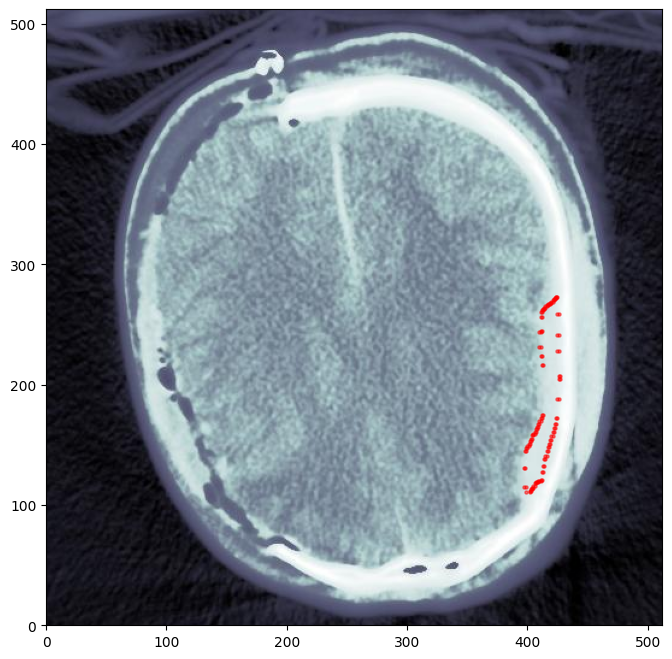

In [51]:
i = 81

photo_type = max_con
st = labels.iloc[i]['Correct Label']
coords = ast.literal_eval(st)

xys = []
for coord in coords:
    xy = [list(v.values()) for v in coord]
    xy = [[element * 512 for element in inner_list] for inner_list in xy]
    xys.append(xy)
    
print(len(xys))

img_id = labels.iloc[i]['Origin']
image_type = labels.iloc[i]['Hemorrhage Type'] + '/'

file_dir

print(file_dir + image_type + photo_type + '/' + img_id)

f, ax = plt.subplots()
f.set_size_inches(8,8)

ax.imshow(mpimg.imread(file_dir + image_type + photo_type + '/' + img_id))

# image will be flipped becasue matplotlib and cv2 have different origins (top left, bottom left)

for xy in xys:
    df = pd.DataFrame(xy)
    ax.scatter(df[0], df[1], s=5, alpha=0.5, c = 'red')
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)

plt.show()


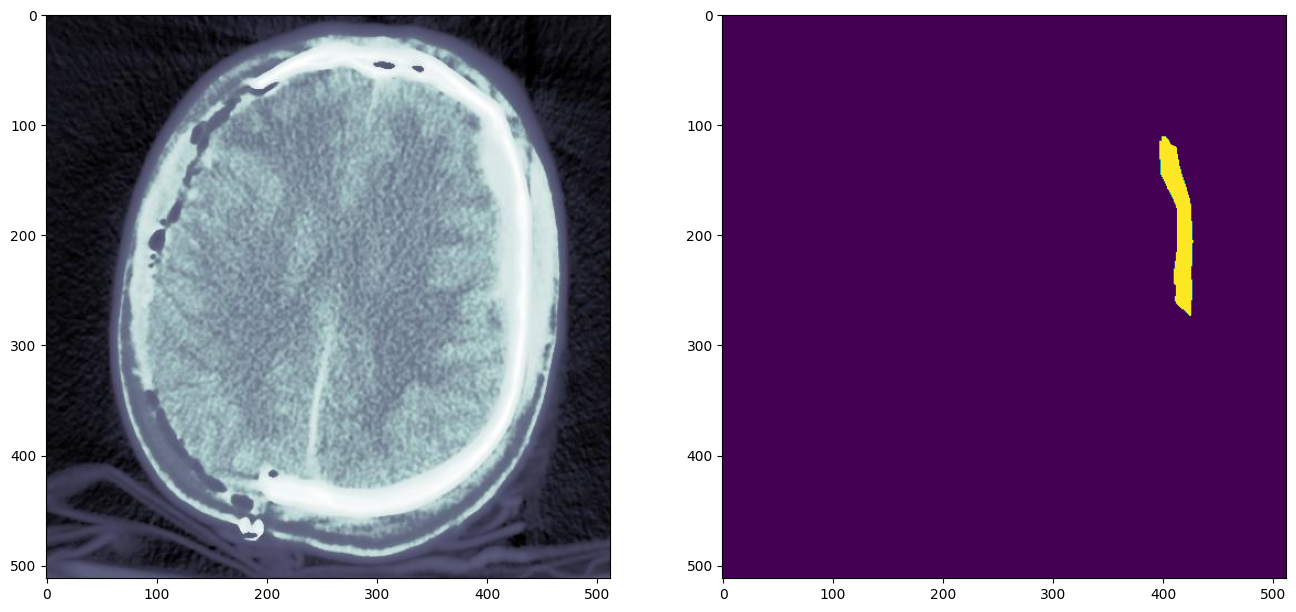

In [52]:
img = np.zeros((512, 512), dtype=np.uint8)

masks = []
for shape in xys:
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, np.int32([shape]), 255)
    masks.append(mask)

s = sum(masks)

img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)

f, ax = plt.subplots(1, 2)
f.set_size_inches(16, 8)

ax[0].imshow(img_orig)
ax[1].imshow(s)

plt.show()

**Data Aggregation**

In [43]:
import tensorflow as tf

2023-03-31 13:18:16.207842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [65]:
seg_df = labels.filter(['Origin','Class'], axis=1)
seg_df['Mask'] = seg_df.Origin
seg_df

,Origin,Class,Mask
0,ID_004c4b319.jpg,1,ID_004c4b319.jpg
1,ID_02e2d273d.jpg,1,ID_02e2d273d.jpg
2,ID_03c6a01ca.jpg,1,ID_03c6a01ca.jpg
3,ID_045196c9f.jpg,1,ID_045196c9f.jpg
4,ID_0513bfa29.jpg,1,ID_0513bfa29.jpg
...,...,...,...
1830,ID_008bbcbc7.jpg,6,ID_008bbcbc7.jpg
1831,ID_002e03abf.jpg,6,ID_002e03abf.jpg
1832,ID_029747d7b.jpg,6,ID_029747d7b.jpg
1833,ID_0184b24fa.jpg,6,ID_0184b24fa.jpg


In [151]:
image_dataset = tf.data.Dataset.from_tensor_slices((seg_df.Origin, seg_df.Mask, seg_df.Class))
image_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [152]:
def load_and_preprocess(image_name, mask_name, label):
    # read resize and normalize image
    image_path = 'u_net_data/images/' + image_name
    image = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(image_decoded, [256, 256]) / 255
    # read resize and normalize mask
    mask_path = 'u_net_data/masks/' + mask_name
    mask = tf.io.read_file(mask_path)
    mask_decoded = tf.image.decode_jpeg(mask, channels=3)
    resized_mask = tf.image.resize(mask_decoded, [256, 256]) / 255
    
    return resized_image, resized_mask, label

In [153]:
image_dataset = image_dataset.map(load_and_preprocess).prefetch(-1)

In [157]:
for x, y, z in image_dataset.take(1):
    print(len(x))
    print(len(y))
    print(z)

256
256
tf.Tensor(1, shape=(), dtype=int64)


In [158]:
# split into train and test
test_size = int(len(image_dataset) * 0.2)

image_dataset = image_dataset.shuffle(buffer_size=len(seg_df))

train_dataset = image_dataset.skip(test_size)
test_dataset = image_dataset.take(test_size)

print("Number of elements in train dataset:", len(list(train_dataset)))
print("Number of elements in test dataset:", len(list(test_dataset)))

Number of elements in train dataset: 1468
Number of elements in test dataset: 367


In [159]:
# perform a single augmentation by randomly flipping an image
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, images, masks, labels):
        inputs = self.augment_inputs(images)
        labels = self.augment_labels(masks)
        return inputs, masks, labels

In [164]:
TRAIN_LENGTH = len(list(train_dataset))
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [165]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)
train_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [179]:
for x,y,z in train_batches.take(1):
    print(f"image batch size: {len(x)}, each with and image of size {len(x[0])}x{len(x[0])}")
    print(f"mask batch size: {len(y)}, each with and image of size {len(y[0])}x{len(y[0])}")
    print(f"label batch size: {len(z)}")


image batch size: 32, each with and image of size 256x256
mask batch size: 32, each with and image of size 256x256
label batch size: 32


In [175]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

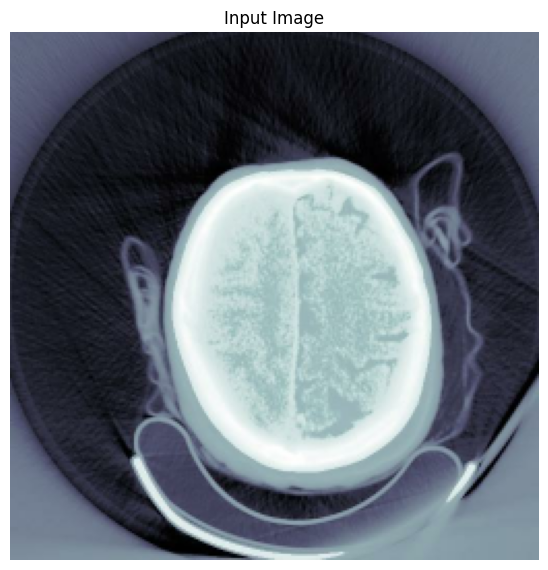

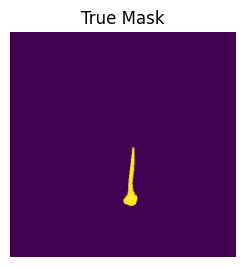

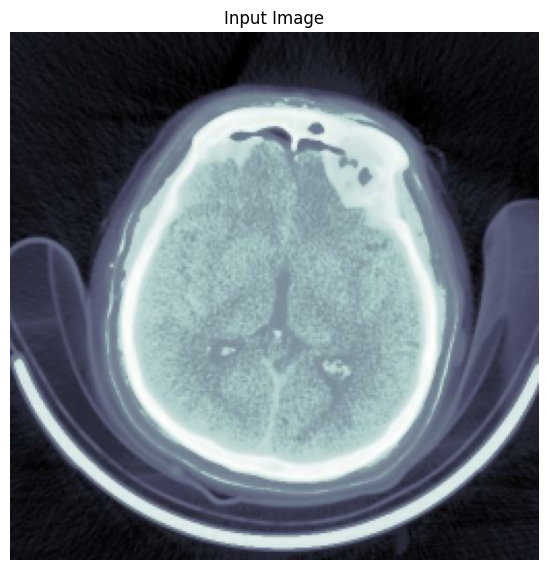

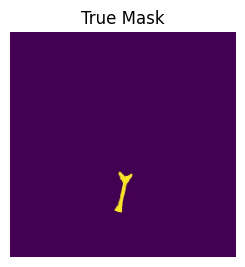

In [178]:
for images, masks, labels in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])